# Chapter 5. 트리 알고리즘
- 성능이 좋고 이해하기 쉬운 트리 알고리즘에 대해 배웁니다.
- 알고리즘의 성능을 최대화하기 위한 **하이퍼파라미터 튜닝**을 실습합니다.
- **여러 트리를 합쳐** 일반화 성능을 높일 수 있는 **앙상블 모델**을 배웁니다

## 05-1 결정 트리
- 트리 알고리즘 전, 분류 모델에 주로 쓰이는 로지스틱 회귀 분석을 사용해봅시다.

### 데이터 준비

In [2]:
import pandas as pd

In [3]:
df1 = pd.read_csv('http://bit.ly/wine_csv_data')

In [4]:
# 데이터 확인
## 데이터 앞 부분 확인
df1.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [5]:
## 데이터 칼럼명 확인
df1.columns

Index(['alcohol', 'sugar', 'pH', 'class'], dtype='object')

- `alcohol`, `sugar`, `pH`은 각각 알코올 도수, 당도, pH 값임
- `class`은 타깃값으로 0이면 레드 와인, 1이면 화이트 와인

In [6]:
## 데이터 타입, null 여부 확인
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


- 누락된 값은 없는 것으로 보임
- 누락된 값은 채우는 방법은 단순 평균값으로 채우거나, 연속형일 경우 Linear Regression으로 진행하여 채우는 경우가 있음

In [7]:
df1.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


- 알코올 도수와 당도, pH 값의 스케일이 다른것을 확인 할 수 있음
- 표준화 필요

In [8]:
# 트레이닝, 테스트 데이터 추출 확인
data = df1[['alcohol', 'sugar', 'pH']]
target = df1['class']


from sklearn.model_selection import train_test_split
# 샘플 개수가충분히 많아 20% 정도만 테스트 세트로
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42) 


In [9]:
print(train_input.shape, test_input.shape)

(5197, 3) (1300, 3)


- 훈련 데이터는 5197개, 테스트 데이터 1300개 확인

In [10]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.7808350971714451
0.7776923076923077


In [12]:
print(lr.coef_, lr.intercept_)

[[ 0.51268071  1.67335441 -0.68775646]] [1.81773456]


- 훈련 데이터 셋도 78프로, 테스트 결과도 77퍼 정도로 높지 않음
- 이 모델이 왜 저런 계수 값을 학습했는지 정확히 이해하기 어려움

### 트리 모델 

In [13]:
# 트리 모델 생성
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target)) # 훈련 세트
print(dt.score(test_scaled, test_target)) 

0.996921300750433
0.8592307692307692


- 훈련 세트 점수는 높으나 (99%), 테스트 세트의 성능은 그에 비해 낮음
- 과대적합이 의심되는 모델임

In [14]:
# 트리 나타내는 방법
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


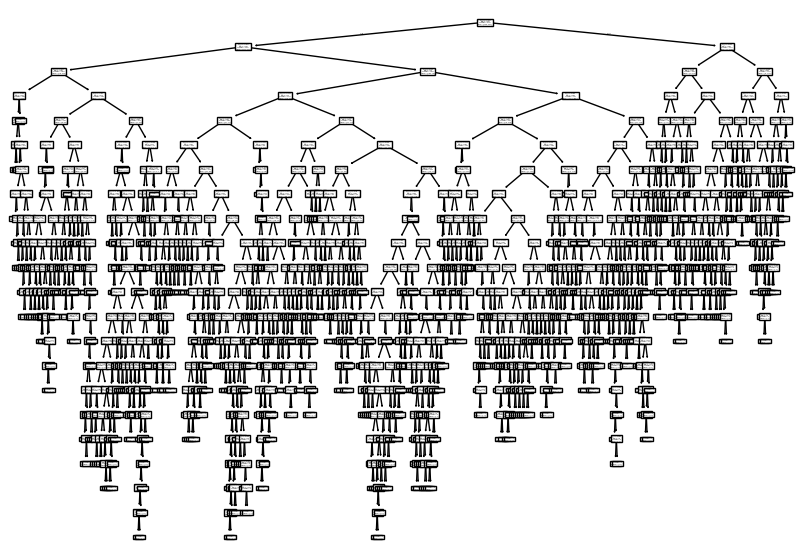

In [15]:
plt.figure(figsize=(10,7))
plot_tree(dt)
plt.show()

- 루트 노드 root node : 맨 위 노드 
- 리프 노드leaf node : 맨 아래 끝에 달린 노드
- 노드는 훈련 데이터의 특성에 대한 테스트를 표현 \
    - 예를 들어 현재 샘플의 당도가 -0.239보다 작거나 같은지 테스트
- 가지(branch)는 테스트의 결과(True, False) 나타내며 하나의 노드는 2개의 가지를 가짐

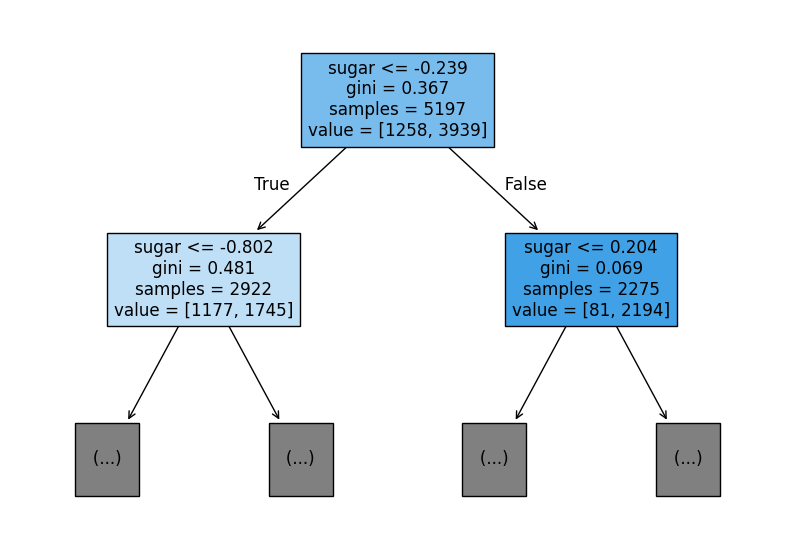

In [16]:
# plot_tree() 함수에서 트리의 깊이를 제한해서 출력
plt.figure(figsize=(10,7))
plot_tree(dt, max_depth=1, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

#### 트리 보는법
![alt text](appendix/image-10.png)

- (첫번째 루트 노드를 기준으로 설명)
- `sugar`가 -0.239 이하인지 확인 하여 이하이면 왼쪽 가지, 초과면 오른쪽 가지로 감
- 루트 노드의 총 샘플 수(samples)는 5,197개인데 이 중에서 음성 클래스(레드 와인)는 1,258개이고, 양성 클래스(화이트 와인)는 3,939개 이므로 각각 `value`값에 표현함
- `gini`는 Gini impurity를 의미하며 계산 법은 아래와 같음
$$
지니\ 불순도 = 1 - ({음성\ 클래스\ 비율}^2 + {양성\ 클래스\ 비율}^2)
$$

- 상기 공식에 따라 첫번째 루트 노드의 지니 계수를 계산하면 아래와 같음

$$
1 - \{(\frac{1258}{5197})^2 + (\frac{3939}{5197})^2\}
$$

#### 결정트리 모델 성장 방법
- 결정 트리 모델은 부모 노드parent node와 자식 노드child node의 불순도 차이가 가능한 크도록 트리를 성장
- information gain: 부모 노드와 자식 노드의 불순도 차이를 계산하는 방법

$$
부모의\ 불순도 - \frac{왼쪽\ 노드\ 샘플\ 수}{부모의\ 샘플\ 수} \times 왼쪽\ 노드\ 불순도 - \frac{오른쪽\ 노드\ 샘플\ 수}{부모의\ 샘플\ 수} \times 오른쪽\ 노드\ 불순도
$$

#### Pruning
- 과대적합을 막기위한 가지 제한이 필요

In [17]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42) # 일단 뎁스를 3으로 제한
dt.fit(train_scaled, train_target) 
print(dt.score(train_scaled, train_target)) 
print(dt.score(test_scaled, test_target))

0.8454877814123533
0.8415384615384616


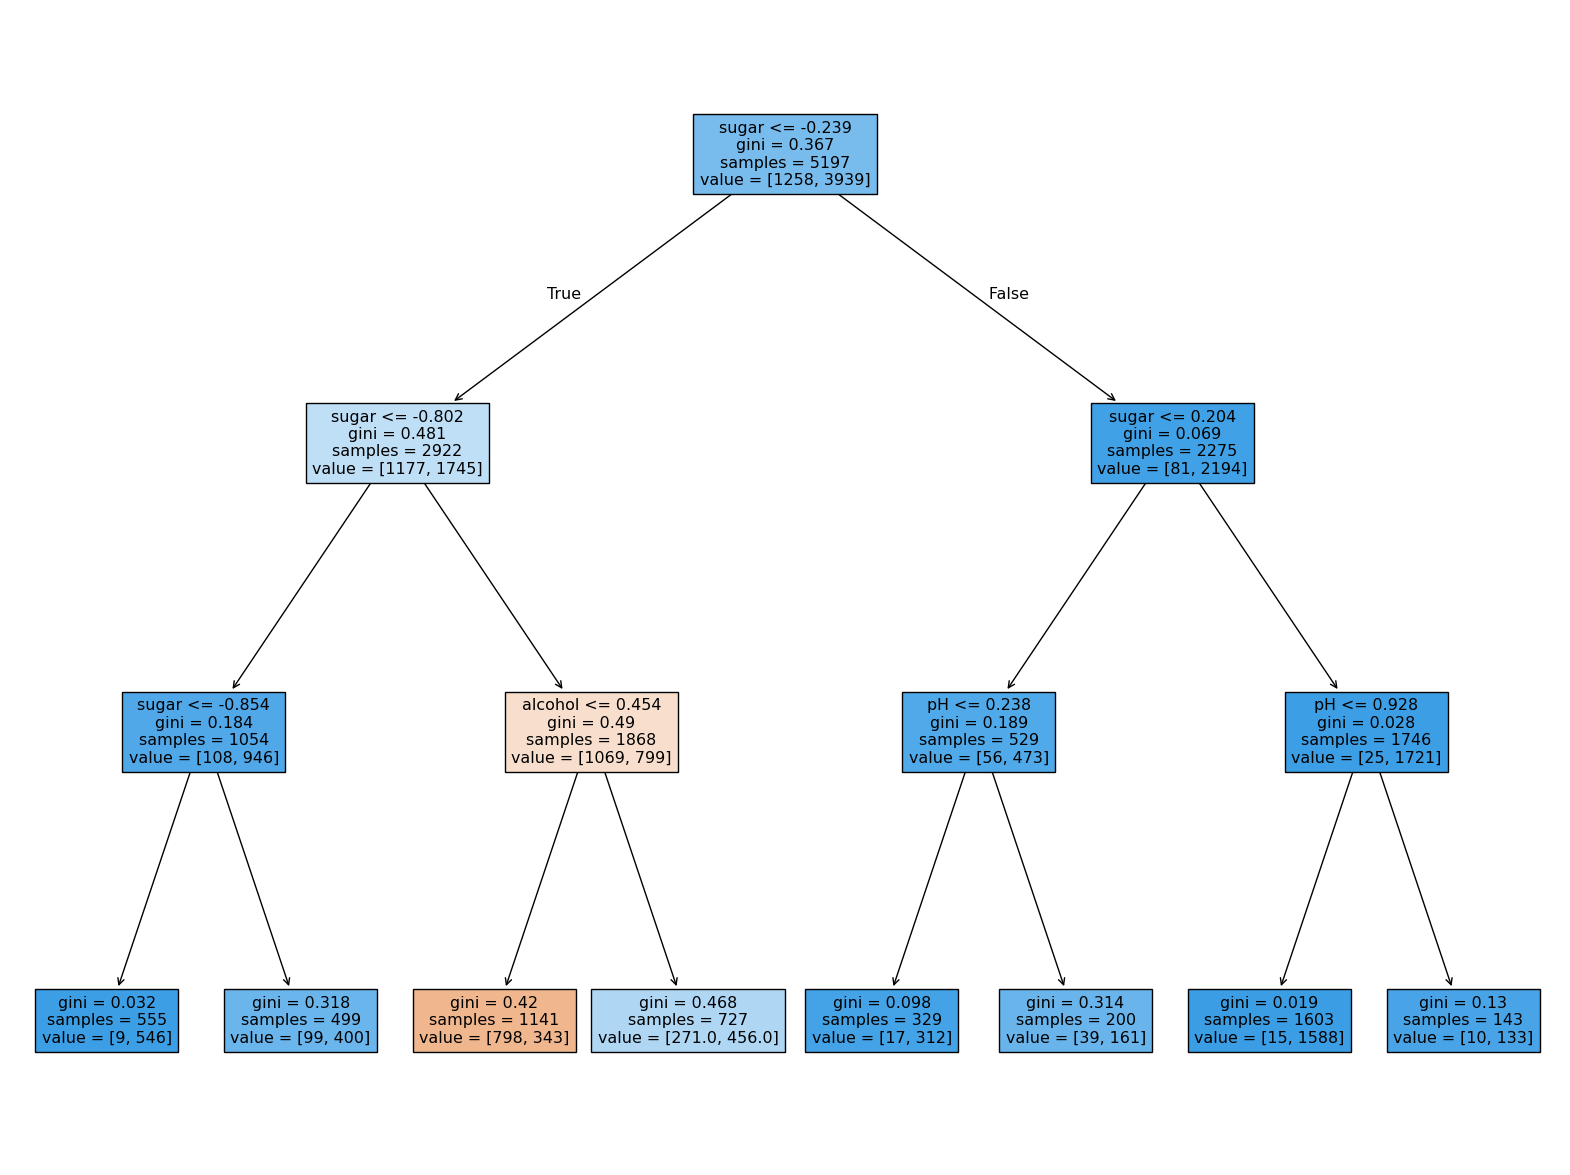

In [18]:
# 결과 figure
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

- 루트 노드 다음에 있는 깊이 1의 노드는 모두 당도(sugar)를 기준으로 훈련 세트를 나눔
- 깊이 2의 노드는 맨 왼쪽의 노드만 당도를 기준으로 나누고 왼쪽에서 두 번째 노드는 알코올 도수(alcohol) 
를 기준으로 나눔
- 오른쪽의 두 노드는 pH를 사용

- 최종 노드들 중, 왼쪽에서 세 번째에 있는 노드만 음성 클래스가 더 많음
    - 이 노드에 도착해야만 레드 와인으로 예측
- 루트 노드부터 이 노드까지 도달하려면 당도는 -0.239보다 작고 또 -0.802보다 커야 함
- 그리고 알코올 도수는 0.454보다 작아야 세 번째 리프 노드에 도달
- 즉 당도가 -0.802보다 크고 -0.239보다 작은 와인 중에 알코올 도수가 0.454와 같거나 작은 것이 레드 와인

In [19]:
# 전처리전 데이터를 다시 사용
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)
print(dt.score(train_input, train_target)) 
print(dt.score(test_input, test_target))

0.8454877814123533
0.8415384615384616


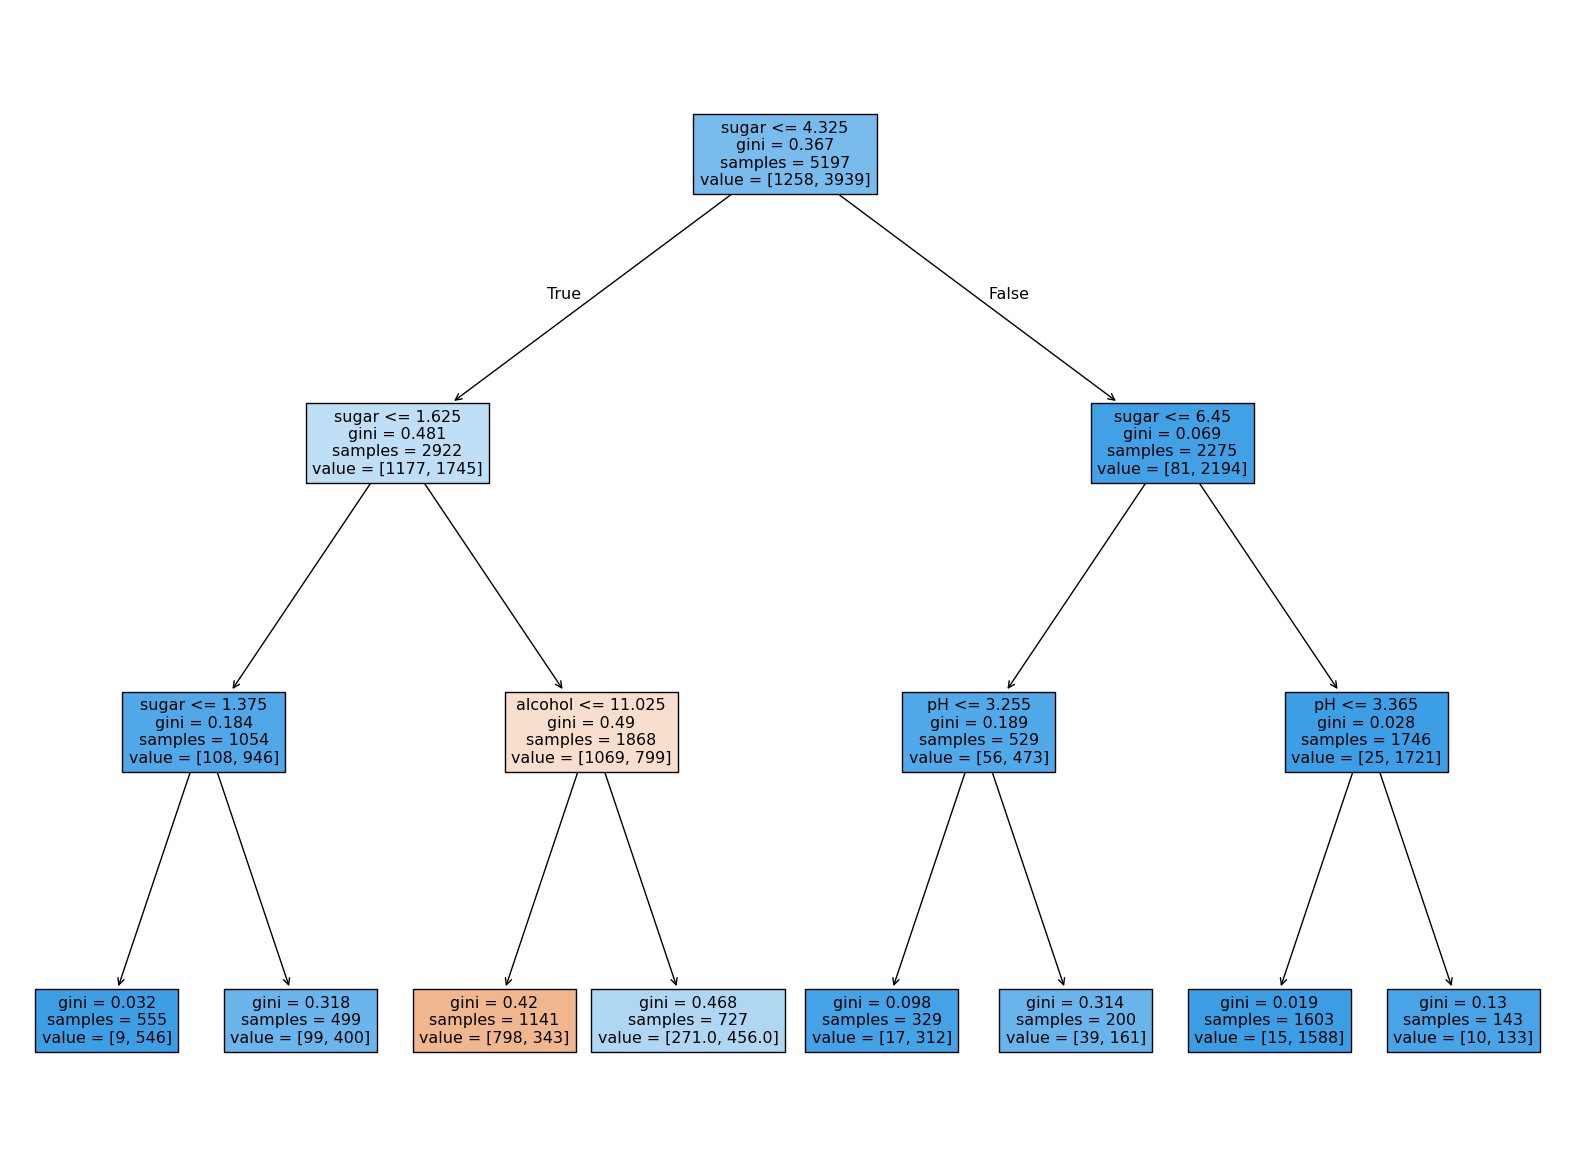

In [20]:
# 결과 figure
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

- 값을 변환한 것이 아니라서 직관적 이해가 가능
    - 예: 당도가 1.625보다 크고 4.325보다 작은 와인 중에 알코올 도수가 11.025와 같거나 작은 것이 레드 와 
인이고 그 외에는 모두 화이트 와인으로 예측

In [21]:
print(dt.feature_importances_)

[0.12345626 0.86862934 0.0079144 ]


- 중요도 순이 `sugar`, `알코올 도수`, `pH` 순으로 나옴

## 05-2 교차 검증과 그리드 서치
-지금까지 우리는 훈련 세트에서 모델을 훈련하고 테스트 세트에서 모델을 평가함
- 테스트 세트에서 얻은 점수를 보고 “아, 이 모델을 실전에 투입하면 이 정도 성능을 기대할 수 있겠군”이라고 
생각; 즉 일반화 성능을 가늠. 
- 그런데 테스트 세트를 사용해 자꾸 성능을 확인하다 보면 점점 테스트 세트에 맞추게 되는 셈
- 이전까지는 문제를 간단히 하려고 테스트 세트를 사용하여 모델을 평가했으나 테스트 세트로 일반화 성능을 올바르게 예측하려면 가능한 한 테스트 세트를 사용하지 말아야 함 
- 모델을 만들고 나서 마지막에 딱 한 번만 사용하는 것이 좋음
- max_depth 매개변수를 사용한 하이퍼파라미터 튜닝에 대해 배움

### 검증 세트
- 그래서 보통 트레이닝 데이터, 밸리데이션 데이터, 테스트 데이터를 나누어 진행함
- 보통 하기와 같이 진행

![alt text](appendix/image-11.png)

- 문제에 따라 데이터 셋을 나누는 것은 유의해야함

In [22]:
# 밸리데이션 데이터 까지 나누는 법
train_input, test_input, train_target, test_target = train_test_split( data, target, test_size=0.2, random_state=42)
## 먼저 테스트 트레인을 나눈 후 트레인 데이터를 나누는 방식 사용
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [23]:
# sub_input, sub_target과 val_input, val_target을 사용
dt = DecisionTreeClassifier(random_state=42) 
dt.fit(sub_input, sub_target) 
print(dt.score(sub_input, sub_target)) 
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


### 교차 검증(Cross Validation)
- 일반적으로 많은 데이터를 훈련에 사용할수록 좋은 모델이 만들어질 확률이 높음
- 단 검증 세트를 너무 조금 떼어 놓으면 검증 점수가 들쭉날쭉하고 불안정한 모델이 나옴
- 훈련 세트를 K 부분으로 나눠서 교차 검증을 수행하는 것을 k-폴드 교차 검증 
(k—fold cross validation)이라고 함

![alt text](appendix/image-12.png)

- 검증 세트가 줄어들지만 각 폴드에서 계산한 검증 점수를 평균하기 때문에 안정된 점수로 생각할 수 있음

- `cross_validate()` : 교차 검증 함수
    - 사용법은 먼저 평가할 모델 객체를 첫 번째 매개변수로 전달한 후, 앞에서처럼 직접 검증 세트를 떼어 내지 않고 훈련 세트 전체를 `cross_validate()` 함수에 전달함
    - fit_time, score_time, test_score 키를 가진 딕셔너리를 반환
        - `fit_time` : 모델 훈련 시간
        - `score_time` : 모델 검증 시간
- `cross_val_score()` : `cross_validate()`함수의 결과 중에서 test_score 값만 반환

In [24]:
from sklearn.model_selection import cross_validate 
scores = cross_validate(dt, train_input, train_target) 
print(scores)

{'fit_time': array([0.01087737, 0.00703621, 0.00676441, 0.0065515 , 0.00618386]), 'score_time': array([0.00182414, 0.00166035, 0.00143313, 0.00129151, 0.00133848]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [25]:
import numpy as np
print(np.mean(scores['test_score']))

0.855300214703487


- cross_validate()는 훈련 세트를 섞어 폴드를 나누지 않습니다. 앞서 우리는 
- train_test_split() 함수로 전체 데이터를 섞은 후 훈련 세트를 준비했기 때문에 따로 섞을 필요가 없으나 만약 교차 검증을 할 때 훈련 세트를 섞으려면 분할기 spider를 지정해야함
-  cross_validate() 함수는 기본적으로 회귀 모델일 경우 KFold 분할기를 사용하고 분류 모델일 경우 타깃 클래스를 골고루 나누기 위해 StratifiedKFold를 사용

In [26]:
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold()) 
print(np.mean(scores['test_score']))

0.855300214703487


In [27]:
# 10-fold 교차 검증 수행하는 방법
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


### 하이퍼파라미터
- 모델이 학습할 수 없어서 사용자가 지정해야만 하는 파라미터

#### 하이퍼파라미터 튜닝 방법
- 라이브러리가 제공하는 기본값을 그대로 사용해 모델을 훈련
- 그다음 검증 세트의 점수나 교차 검증을 통해서 매개변수를 조금씩 바꿈 
- 모델마다 적게는 1 〜2개에서, 많게는 5~6개의 매개변수를 제공하며 이 
매개변수를 바꿔가면서 교차 검증을 수행
-  사람의 개입 없이 하이퍼파라미터 튜닝을 자동으로 수행하는 기술을 ‘AutoML’이라고 함
- 하이퍼파라미터에서 여러가지 경우의 수의 하이퍼파라미터 조합의 계산을 하기 위해 `GridSearchCV` 클래스를 제공

1)  먼저 `GridSearchCV` 클래스를 임포트하고 탐색할 매개변수와 탐색할 
값의 리스트를 딕셔너리 객체 생성
2)  객체에 `fit()` 메서드를 호출
3) `GridSearchCV`는 훈련이 끝나면 교차 검증 점수가 가장 높은 모델의 매개변수 조합으로 전체 훈련 세트에서 자동으로 다시 모델을 훈련
    - 최상의 매개변수에서 (교차 검증에 사용한 훈련 세트가 아니라) 전체 훈련 세트를 사용해 최종 모델을 훈련

In [28]:
# 하이퍼 파라미터 진행
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [29]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1) # -1옵션은 모든 CPU 코어 사용

In [30]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [31]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [32]:
# 선택된 최적 파라미터 값
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [33]:
# 각 매개변수에서 수행한 교차 검증의 평균 점수
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [34]:
print(gs.cv_results_['params'][gs.best_index_])

{'min_impurity_decrease': 0.0001}


In [35]:
# min_impurity_decrease, max_depth, min_samples_split 진행
params = {
    'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
    'max_depth': range(5, 20, 1),
    'min_samples_split': range(2, 100, 10) 
}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1) 
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [36]:
# 하이퍼파라미터 최적 조합 결과
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': np.float64(0.0004), 'min_samples_split': 12}


In [37]:
# 교차 검증함수 확인
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


### 랜덤 서치
- 앞전 `GridSearchCV` 탐색할 매개변수의 간격을 0.0001 혹은 1로 설정했으나 특별한 근거가 없이 진행함
- 매개변수의 값이 수치일 때 값의 범위나 간격을 미리 정하기 어려울 수 있을 때, 또 너무 많은 매개변수 조건이 있어 그리드 서치 수행 시간이 오래 걸릴거 같은데 일단 랜덤 서치로 대략적인 하이퍼파라미터 구간을 잡을 수 있음

- 랜덤 서치용 파라미터 객체 만들 때에는 `RandomizedSearchCV` 사용
- 랜덤 서치에는 매개변수 값의 목록을 전달하는 것이 아니라 매개변수를 샘플링할 수 있는 **확률 분포 객체를 전달**

In [38]:
from scipy.stats import uniform, randint
rgen = randint(0, 10)
rgen.rvs(10)

array([7, 6, 6, 0, 5, 3, 8, 8, 0, 6])

In [39]:
# 1000개 샘플링
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([102,  97, 117,  93,  92,  98,  90,  94, 114, 103]))

In [40]:
# 0~1 사이에서 10개의 실수를 추출
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.42345906, 0.19710539, 0.41218821, 0.94093162, 0.78199499,
       0.95435697, 0.90806878, 0.27983144, 0.43499151, 0.8545405 ])

In [41]:
# 확률 분포를 객체로 잡은 parameter 객체 생성
params = {'min_impurity_decrease': uniform(0.0001, 0.001), 
          'max_depth': randint(20, 50),
          'min_samples_split' : randint(2, 25), 
          'min_samples_leaf': randint(1, 25), 
}

In [42]:
# 랜던서치
from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_iter=100, n_jobs=-1, random_state=42)
rs.fit(train_input, train_target)


RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x75be7ff580d0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x75be7fd091d0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x75be7fd0c9d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x75be80246e10>},
                   random_state=42)

In [43]:
# 결과 확인
print(rs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': np.float64(0.00034102546602601173), 'min_samples_leaf': 7, 'min_samples_split': 13}


In [44]:
print(np.max(rs.cv_results_['mean_test_score']))

0.8695428296438884


In [45]:
dt = rs.best_estimator_
print(dt.score(test_input, test_target))

0.86


## 05-3 트리의 앙상블 : 랜덤 포레스트
### 랜덤 포레스트
- 여러개의 트리모형의 결과를 합쳐 최적 트리 산출

1) 랜덤 포레스트는 각 트리를 훈련하기 위한 데이터를 랜덤하게 만듦
    - 부트스트랩 샘플을 만듦: 입력한 훈련 데이터에서 랜덤하게 샘플을 복원추출(중복 허용)
2) 각 노드를 분할할 때 전체 특성 중에서 일부 특성을 무작위로 고른 다음 이 중에서 최선의 분할을 찾음
    - RandomForestClassifier는 기본적으로 전체 특성 개수의 제곱근만큼의 특성을 선택(즉 4개의 특성이 있다면 노드마다 2개를 랜덤하게 선택) 
    - RandomForestRegressor는 전체 특성 사용

In [46]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

In [47]:
# 결과 확인
scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9973541965122431 0.8905151032797809


- 훈련 데이터가 99프로인데 반해 테스트 데이터가 89프로로 훈련 세트에 다소 과대적합된 것을 확인

In [48]:
rf.fit(train_input, train_target)
print(rf.feature_importances_)

[0.23167441 0.50039841 0.26792718]


- 각각 [알코올 도수, 당도, pH]였는데, 두 번째 특성인 당도의 중요도가 감소하고 알코올 도수와 pH 특성의 중요도가 조금 상승 함
- 이런 이유는 랜덤 포레스트가 특성의 일부를 랜덤하게 선택하여 결정 트리를 훈련하기 때문
- 그 결과 하나의 특성에 과도하게 집중하지 않고 좀 더 많은 특성이 훈련에 기여할 기회를 얻음
- 이는 과대적합을 줄이고 일반화 성능을 높이는 데 도움이 됨

- `RandomForestClassifier`에는 재미있는 기능이 하나 더 있는데, 자체적으로 모델을 평가하는 점수를 얻을 수 있음
- 랜덤 포레스트는 훈련 세트에서 중복을 허용하여 부트스트랩 샘플을 만들어 결정 트리를 훈련
- 이때 부트스트랩 샘플에 포함되지 않고 남는 샘플 OOB(Out of Bag) 샘플이라고 함 
- 이 남는 샘플을 사용하여 부트스트랩 샘플로 훈련한 결정 트리를 평가

In [50]:
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)
rf.fit(train_input, train_target)
print(rf.oob_score_)

0.8934000384837406


- 교차 검증에서 얻은 점수(0.8905151032797809) 와 매우 비슷한 결과

### 엑스트라 트리Extra Trees
- 랜덤 포레스트와 매우 비슷하게 동작
- 기본적으로 100개의 결정 트리를 훈련
- 랜덤 포레스트와 동일하게 결정 트리가 제공하는 대부분의 매개변수를 지원
- 랜덤 포레스트와 다르게 부트스트랩 샘플을 사용하지 않고 각 결정 트리를 만들 때 전체 훈련 세트를 사용
    - 노드를 분할할 때 가장 좋은 분할을 찾는 것이 아니라 무작위로 분할
    - `splitter='random'`인 결정 트리

In [52]:
# 엑스트라 트리
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_jobs=-1, random_state=42) 
scores = cross_validate(et, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score'])) 

0.9974503966084433 0.8887848893166506


- 트레이닝 데이터 스코어, 테스트 데이터 스코어 모두 랜덤 포레스트 결과와 비슷하게 나옴

In [53]:
# 엑스트라 트리의 특성 중요도 결과 확인
et.fit(train_input, train_target) 
print(et.feature_importances_)

[0.20183568 0.52242907 0.27573525]


- 좌측 부터 알코올 도수, 당도, pH순

### 그래디언트 부스팅
- 깊이가 얕은 결정 트리를 사용하여 이전 트리의 오차를 보완하는 방식으로 앙상블
- 사이킷런의 `GradientBoostingClassifier`는 기본적으로 깊이가 3인 결정 트리를 100개 사용
- 깊이가 얕은 결정 트리를 사용하기 때문에 과대적합에 강하고 일반적으로 높은 일반화 성능을 기대할 수 있음
- 4장에서 배웠던 경사 하강법 사용하여 트리를 앙상블에 추가함
- 그래디언트 디센트가 손실함수가 최소가 되는 값을 찾는 것 처럼 그래디언트 부스팅은 

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8881086892152563 0.8720430147331015


- 그레이디언트 부스팅은 결정 트리의 개수를 늘려도 과대적합에 매우 강함(테스트 데이터 결과 확인)

In [55]:
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2,random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9464595437171814 0.8780082549788999


- 결정 트리 개수를 500개로 5배나 늘렸지만 과대적합을 잘 억제된 것을 볼 수 있음

In [58]:
# 특성 중요도 결과
gb.fit(train_input, train_target) 
print(gb.feature_importances_)

[0.15887763 0.6799705  0.16115187]


- 좌측 부터 알코올 도수, 당도, pH순
- 당도에 더 집중된 것을 확인 할 수 있음

#### subsample 
-  해당 매개변수의 기본값은 1.0으로 전체 훈련 세트를 사용
- 하지만 subsample이 1보다 작으면 훈련 세트의 일부를 사용합
- 경사 하강법 단계마다 일부 샘플을 랜덤하게 선택하여 진행하는 확률적 경사 하강법 이나 미니 배치 경사 하강법과 비슷

- 일반적으로 그레이디언트 부스팅이 랜덤 포레스트보다 조금 더 높은 성능을 얻을 수 있음 
- 단점으로 순서 대로 트리를 추가하기 때문에 훈련 속도가 느립
    - GradientBoostingClassifier에는 `njobs` 매개변수가 없음
- 그레이디언트 부스팅의 회귀 버전은 GradientBoostingRegressor 



### 히스토그램 기반 그래디언트 부스팅
- 그레이디언트 부스팅의 속도와 성능을 더욱 개선
- 정형 데이터를 다루는 머신러닝 알고리즘 중에 가장 인기가 높은 알고리즘
- 입력 특성을 256개의 구간으로 나누기 때문에, 노드를 분할할 때 최적의 분할을 매우 빠르게 찾을 수 있음
- `HistGradientBoostingClassifier`는 기본 매개변수에서 안정적인 성능을 얻음
    - 트리의 개수를 지정하는데 부스팅 반복 횟수를 지정하는 `max_iter`사용

In [59]:
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier 
hgb = HistGradientBoostingClassifier(random_state=42) 
scores = cross_validate(hgb, train_input, train_target,return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

/home/user/miniforge3/envs/mldl/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


0.9321723946453317 0.8801241948619236


- 히스토그램 기반 그레이디언트 부스팅은 자체적으로 특성 중요도를 제공하지 않음
- 중요도를 계산하기 위해 `permutation_importance()` 함수를 사용

In [60]:
from sklearn.inspection import permutation_importance
hgb.fit(train_input, train_target)
result = permutation_importance(hgb, train_input, train_target, n_repeats=10, random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.08876275 0.23438522 0.08027708]


- `permutation_importance()`가 반환하는 객체는 반복하여 얻은 특성 중요도(importances), 평균(importances_mean), 표준 편차(importances_std)가 있음
- 평균을 출력해 보면 랜덤 포레스트와 비슷한 비율임

In [61]:
result = permutation_importance(hgb, test_input, test_target, n_repeats=10, random_state=42, n_jobs=-1)
print(result.importances_mean)

[0.05969231 0.20238462 0.049     ]


- 역시 당도에 중요도가 높은걸 확인 할 수 있음

In [62]:
hgb.score(test_input, test_target)

0.8723076923076923

- 테스트 결과 87% 정도 정확도를 얻음

#### XGBoost
- 사이킷런에서 제공하는 히스토그램 기반 그레이디 언트 부스팅 말고도 그레이디언트 부스팅 알고리즘을 구현한 라이브러리
- 사이킷런의 `cross_yalidate()` 함수와 함께 사용가능
- `tree_method='hist'`로 지정하면 히스토그램 기반 그 레이디언트 부스팅을 사용

In [67]:
from xgboost import XGBClassifier
xgb = XGBClassifier(tree_method='hist', random_state=42) 
scores = cross_validate(xgb, train_input, train_target, return_train_score=True, n_jobs=-1)
print (np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9567059184812372 0.8783915747390243


#### LightGBM
- 마이크로소프트에서 만든 히스토그램 기반 그래디언드 부스팅
- 사이킷런의 히스토그램 기반 그레디언트 부스팅이 LightGBM에서 영향을 많이 qkedma

In [69]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=42)


In [70]:
scores = cross_validate(lgb, train_input, train_target, return_train_score=True, n_jobs=-1)


[LightGBM] [Info] Number of positive: 3152, number of negative: 1006
[LightGBM] [Info] Number of positive: 3151, number of negative: 1006
[LightGBM] [Info] Number of positive: 3151, number of negative: 1006
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101853 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Number of positive: 3151, number of negative: 1007
[LightGBM] [Info] Number of data points in the train set: 4158, number of used features: 3
[LightGBM] [Info] Total Bins 372

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the t

In [71]:
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.935828414851749 0.8801251203079884
